# 1. Setups and Get Data

##### 1.1 Collect Data using OpenCV

In [1]:
import cv2
import time
import uuid # uniform unique id
import os

In [2]:
IMG_PATH = os.path.join('data', 'images')
n_img = 10

In [4]:
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Cannot Open the camera")
else:
    for img_num in range(n_img):
        print(f"Collecting img: {img_num}")
        ret, frame = cap.read()

        if not ret:
            print("Error: Failed to capture image.")
            continue

        img_name = os.path.join(IMG_PATH, f"{str(uuid.uuid1())}.jpg")
        cv2.imwrite(img_name, frame)
        cv2.imshow('frame', frame)
        time.sleep(.5)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

##### 1.2 Annotate Images with LabelMe

In [50]:
!labelme

2024-05-16 07:14:04,415 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\Mehul\.labelmerc


# 2. Review Datasets and Build Image Loading Function

##### 2.1 Import Dependencies

In [2]:
import tensorflow as tf
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt

##### 2.2 Limit GPU Memeory Growth

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
tf.test.is_gpu_available()

False

##### 2.3 Load Images in TF Pipeline

In [9]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg', shuffle=True)

In [10]:
images.as_numpy_iterator().next()

b'data\\images\\7847db30-14b4-11ef-994c-50c2e8342558.jpg'

In [5]:
def load_images(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [12]:
images = images.map(load_images)

In [13]:
images.as_numpy_iterator().next()

array([[[ 46,  41,  22],
        [ 49,  44,  25],
        [ 51,  46,  27],
        ...,
        [ 58,  45,  52],
        [ 51,  38,  48],
        [ 45,  32,  42]],

       [[ 47,  42,  23],
        [ 48,  43,  24],
        [ 48,  43,  24],
        ...,
        [ 54,  41,  48],
        [ 48,  35,  44],
        [ 46,  33,  43]],

       [[ 45,  42,  25],
        [ 43,  40,  23],
        [ 45,  39,  23],
        ...,
        [ 54,  41,  48],
        [ 49,  36,  45],
        [ 47,  34,  43]],

       ...,

       [[  9,   9,   7],
        [ 10,  10,   8],
        [ 11,  11,   9],
        ...,
        [254, 255, 255],
        [254, 255, 255],
        [254, 255, 255]],

       [[  8,   8,   6],
        [  9,   9,   7],
        [ 10,  10,   8],
        ...,
        [252, 255, 255],
        [252, 255, 255],
        [252, 255, 255]],

       [[  9,   9,   7],
        [  8,   8,   6],
        [  9,   9,   7],
        ...,
        [252, 255, 255],
        [252, 255, 255],
        [252, 255, 255]]

##### 2.4 View Images using Matplotlib

In [14]:
img_generator = images.batch(4).as_numpy_iterator()

In [15]:
plot_img = img_generator.next()

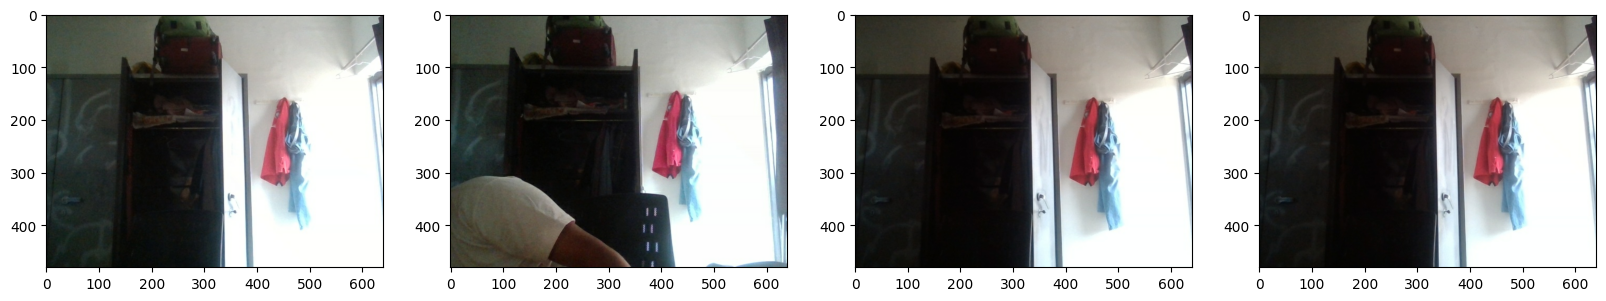

In [16]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, image in enumerate(plot_img):
    ax[idx].imshow(image)
plt.show()

# 3. Partition Unaugmented Data

##### 3.1 Manually Split Data Into Train, Testing and Validation Sets

In [17]:
90*.7 # 63 images for training set

9.1

In [8]:
90*.15 # 14 and 13 images for testing and validation set

13.5

##### 3.2 Move the Matching Labels

In [18]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data', 'labels', filename)

        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

# 4. Apply Image Augmentation on Images and Labels using Albumentations

##### 4.1 Setup Albumentations Transform Pipeline

In [3]:
import albumentations as alb
# https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/

In [4]:
augmentor = alb.Compose([
    alb.RandomCrop(width=450, height=450),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5)
], bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

##### 4.2 Load a Test Image and Annotation with OpenCV and Json

In [9]:
img = cv2.imread(os.path.join('data', 'train', 'images', '9a23e5ef-12c3-11ef-9675-50c2e8342558.jpg'))

In [10]:
with open(os.path.join('data', 'train', 'labels', '9a23e5ef-12c3-11ef-9675-50c2e8342558.json'), 'r') as file:
    label = json.load(file)

In [11]:
label['shapes'][0]['points']

[[239.53125, 118.12499999999999], [507.2395833333333, 429.5833333333333]]

##### 4.3 Extract Coordinates and Rescale to Math Image Resolution

In [12]:
coords = [0, 0, 0, 0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [13]:
coords

[239.53125, 118.12499999999999, 507.2395833333333, 429.5833333333333]

In [14]:
coords = list(np.divide(coords, [640, 480, 640, 480]))

In [15]:
coords

[0.374267578125, 0.24609374999999997, 0.7925618489583333, 0.8949652777777778]

##### 4.4 Apply Augmentations and View and Results

In [16]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [17]:
augmented['bboxes'][0][:2]

(0.12613425925925947, 0.058703703703703695)

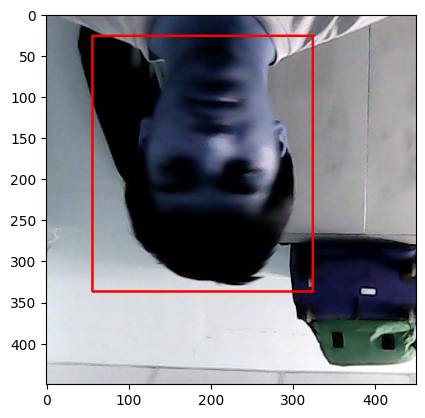

In [18]:
cv2.rectangle(augmented['image'],
            tuple(np.multiply(augmented['bboxes'][0][:2], [450, 450]).astype(int)),
            tuple(np.multiply(augmented['bboxes'][0][2:], [450, 450]).astype(int)),
            (255, 0, 0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

##### 5.1 Run Augmentation Pipeline

In [28]:
for partition in ['train2','test2','val2']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0, 0, 0.00001, 0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0, 0, 0, 0]
                        annotation['class'] = 0
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

##### 5.2 Load Augmented Images in Tensorflow

In [6]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_images)
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x: x/255)

In [7]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_images)
test_images = test_images.map(lambda x: tf.image.resize(x, (120, 120)))
test_images = test_images.map(lambda x: x/255)

In [8]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_images)
val_images = val_images.map(lambda x: tf.image.resize(x, (120, 120)))
val_images = val_images.map(lambda x: x/255)

In [9]:
train_images.as_numpy_iterator().next()

array([[[0.18039216, 0.25392157, 0.2509804 ],
        [0.16384804, 0.23872548, 0.23118873],
        [0.18192402, 0.23431373, 0.22469363],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[0.19019608, 0.2754902 , 0.26421568],
        [0.18860294, 0.26697305, 0.25686276],
        [0.184375  , 0.24375   , 0.23094362],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[0.22965686, 0.29203433, 0.27996323],
        [0.2151348 , 0.27745098, 0.26568627],
        [0.19234069, 0.23658088, 0.22083333],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       ...,

       [[0.37892157, 0.44166666, 0.39558825],
        [0.38737744, 0.45012254, 0.39914215],
        [0.4189338 , 0

# 6. Prepare Labels

##### 6.1 Building Label loading Function

In [10]:
def load_labels(labels_path):
    with open(labels_path.numpy(), 'r', encoding="utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bbox']

##### 6.2 Load Labels to Tensorflow Dataset

In [11]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [12]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [13]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [14]:
train_labels.as_numpy_iterator().next()

(array([0], dtype=uint8), array([0., 0., 0., 0.], dtype=float16))

# 7. Combine Label and Image Samples

##### 7.1 Check Partition Length

In [15]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(4320, 4320, 960, 960, 900, 900)

##### 7.2 Create Final Dataset(Images/Labels)

In [16]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [17]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [18]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [19]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.7393  , 0.588   , 1.      , 1.      ],
        [0.      , 0.      , 0.      , 0.      ],
        [0.05295 , 0.525   , 0.4082  , 1.      ],
        [0.632   , 0.04028 , 1.      , 0.6377  ],
        [0.3052  , 0.547   , 0.649   , 1.      ],
        [0.0635  , 0.07166 , 0.6836  , 0.745   ],
        [0.      , 0.3335  , 0.3704  , 0.9307  ],
        [0.1788  , 0.003334, 0.5645  , 0.4768  ]], dtype=float16))

##### 7.3 View Images and Annotations

In [20]:
data_samples = train.as_numpy_iterator()

In [26]:
res = data_samples.next()

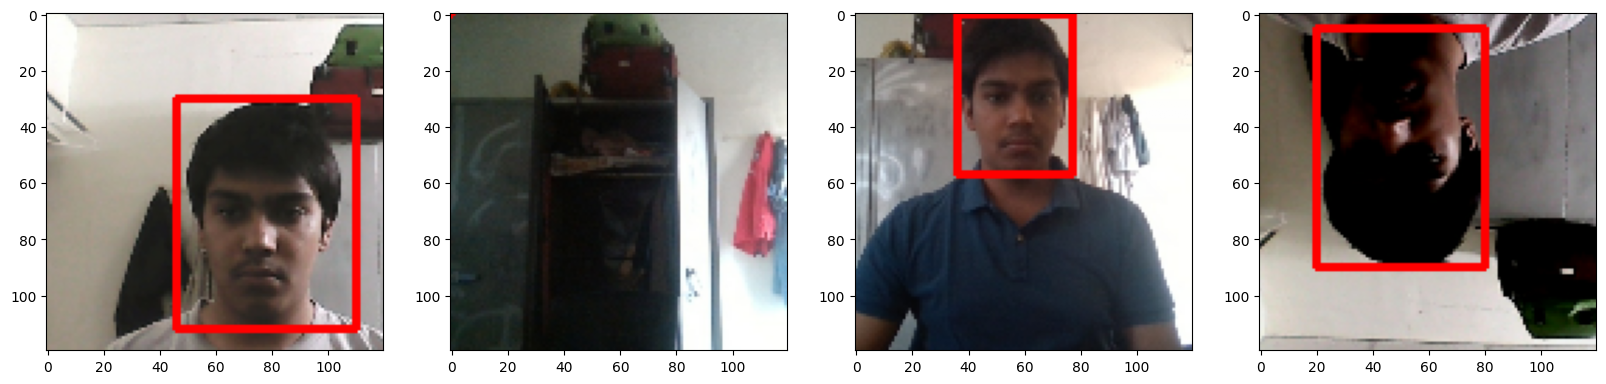

In [27]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = np.copy(res[0][idx])
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)), 
                        (255, 0, 0), 2)

    ax[idx].imshow(sample_image)

# 8. Building Deep Learning usin Functional API

##### 8.1 Import Base Layers and Base Network

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

##### 8.2 Download VGG16

In [29]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 16s 0us/step


In [30]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

##### 8.3 Build Instance of Network

In [31]:
def Build_model():
    input_layer = Input(shape=(120, 120, 3))

    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    # Bounding Box Model
    f2 = GlobalMaxPooling2D()(vgg)
    regression1 = Dense(2048, activation='relu')(f2)
    regression2 = Dense(4, activation='sigmoid')(regression1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regression2])
    return facetracker

##### 8.4 Test out Neural Network

In [32]:
facetracker = Build_model()

In [33]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [34]:
X, y = train.as_numpy_iterator().next()

In [42]:
X.shape

(8, 120, 120, 3)

In [43]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 1s/step


In [46]:
classes, coords

(array([[0.750595  ],
        [0.7582703 ],
        [0.69774973],
        [0.687369  ],
        [0.7256621 ],
        [0.69425416],
        [0.65843415],
        [0.73388386]], dtype=float32),
 array([[0.34290543, 0.34249443, 0.630699  , 0.742409  ],
        [0.3592176 , 0.24338229, 0.6085727 , 0.78013057],
        [0.41356224, 0.28306225, 0.5975607 , 0.7541167 ],
        [0.4097426 , 0.35324317, 0.58149284, 0.76463056],
        [0.44136745, 0.32753336, 0.592932  , 0.70690453],
        [0.46596637, 0.27707714, 0.60113984, 0.758     ],
        [0.4726989 , 0.25417763, 0.60028005, 0.7148494 ],
        [0.44111317, 0.30449465, 0.65426695, 0.736441  ]], dtype=float32))

# 9. Define Losses and Optimizers

##### 9.1 Define Optimizer and LR

In [48]:
batches_per_epoches = len(train)
lr_decay = (1/0.75 - 1)/batches_per_epoches

In [50]:
lr_decay

0.0006172839506172838

In [53]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

##### 9.2 Create Localization Loss and Classification Loss

In [54]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:, :2] - yhat[:, :2]))

    h_true = y_true[:, 3] - y_true[:, 1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [55]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressionloss = localization_loss

##### 9.3 Test out Loss Metrics

In [63]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=1.3798031>

In [64]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.33890814>

In [65]:
regressionloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=1.3798031>

# 10. Train Neural Network

##### 10.1 Create a Custom Model Class

In [71]:
# Model Subclassing with keras
class FaceTracker(Model):
    def __init__(self, facetracker, **kwargs):
        super().__init__(**kwargs)
        self.model = facetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.opt = opt
        self.closs = classloss
        self.lloss = localizationloss

    def train_step(self, batch, **kwargs):
        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = (0.5*batch_classloss) + batch_localizationloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = (0.5*batch_classloss) + batch_localizationloss

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)


In [72]:
model = FaceTracker(facetracker)

In [73]:
model.compile(opt, classloss, regressionloss)

##### 10.2 Train Model

In [74]:
logdir = 'logs'

In [76]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [77]:
hist = model.fit(train.take(100), epochs=40, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/40
100/100 [==============================] - 209s 2s/step - total_loss: 0.9198 - class_loss: 0.2044 - regress_loss: 0.8176 - val_total_loss: 0.0521 - val_class_loss: 0.0076 - val_regress_loss: 0.0483
Epoch 2/40
100/100 [==============================] - 157s 2s/step - total_loss: 0.2387 - class_loss: 0.0356 - regress_loss: 0.2209 - val_total_loss: 0.0389 - val_class_loss: 2.6692e-04 - val_regress_loss: 0.0388
Epoch 3/40
100/100 [==============================] - 155s 1s/step - total_loss: 0.1544 - class_loss: 0.0363 - regress_loss: 0.1363 - val_total_loss: 0.0968 - val_class_loss: 0.0028 - val_regress_loss: 0.0953
Epoch 4/40
100/100 [==============================] - 152s 1s/step - total_loss: 0.1162 - class_loss: 0.0232 - regress_loss: 0.1046 - val_total_loss: 0.0196 - val_class_loss: 7.7332e-04 - val_regress_loss: 0.0192
Epoch 5/40
100/100 [==============================] - 153s 1s/step - total_loss: 0.1139 - class_loss: 0.0187 - regress_loss: 0.1045 - val_total_loss: 0.0300

##### 10.3 Plot Performance

In [78]:
hist.history

{'total_loss': [0.4553002715110779,
  0.11094046384096146,
  0.203860342502594,
  0.36784809827804565,
  0.07194509357213974,
  0.0292496457695961,
  0.018678508698940277,
  0.012358089908957481,
  0.06223631277680397,
  0.021241970360279083,
  0.09032852202653885,
  0.05255904793739319,
  0.01919449493288994,
  0.028330273926258087,
  0.01476963423192501,
  0.06501265615224838,
  0.012258755974471569,
  0.027127480134367943,
  0.011530749499797821,
  0.012809233739972115,
  0.011103179305791855,
  0.021640758961439133,
  0.010896462015807629,
  0.011370989494025707,
  0.01132506038993597,
  0.010471316054463387,
  0.00990099273622036,
  0.015475967898964882,
  0.009156959131360054,
  0.023690951988101006,
  0.019836099818348885,
  0.006985361687839031,
  0.004517535679042339,
  0.0036261549685150385,
  0.01165761984884739,
  0.010272424668073654,
  0.0052946629002690315,
  0.00544467568397522,
  0.007915878668427467,
  0.002773650921881199],
 'class_loss': [0.1479204297065735,
  0.018

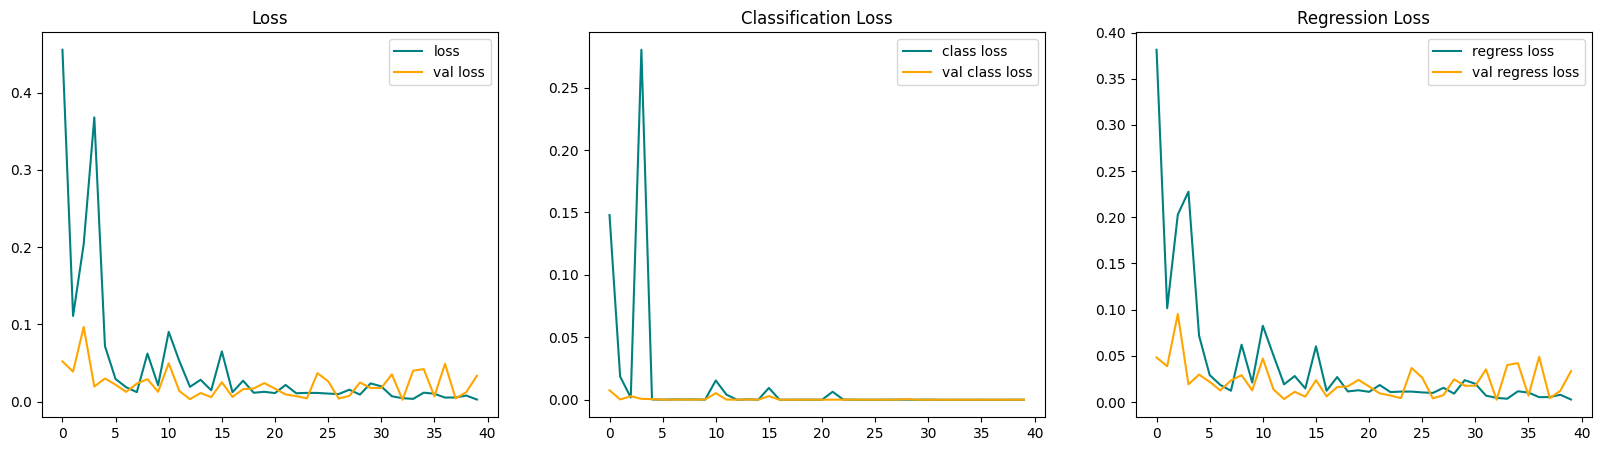

In [79]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

##### 11.1 Make Predictions on Test Set

In [80]:
test_data = test.as_numpy_iterator()

In [91]:
test_sample = test_data.next()

In [96]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 404ms/step


In [97]:
yhat

[array([[1.1403308e-20],
        [9.9987173e-01],
        [9.9995047e-01],
        [8.2630860e-21],
        [9.9998093e-01],
        [9.9992305e-01],
        [9.9988669e-01],
        [9.4235763e-13]], dtype=float32),
 array([[2.2241489e-10, 2.0522320e-10, 3.4491965e-09, 4.2263640e-10],
        [3.1107980e-01, 5.3866923e-01, 6.5942538e-01, 9.8853642e-01],
        [3.1250966e-01, 3.0577332e-01, 8.5216963e-01, 9.4829625e-01],
        [1.3642056e-10, 1.7770450e-10, 3.0616643e-09, 4.3734755e-10],
        [4.2320434e-03, 4.0557307e-01, 2.7872562e-01, 9.6365309e-01],
        [2.2042127e-01, 5.2064216e-01, 5.8601737e-01, 9.8914671e-01],
        [3.6546052e-01, 5.6484360e-01, 6.9854367e-01, 9.9101937e-01],
        [1.1986109e-06, 2.6011801e-06, 9.9947174e-06, 2.8693066e-06]],
       dtype=float32)]

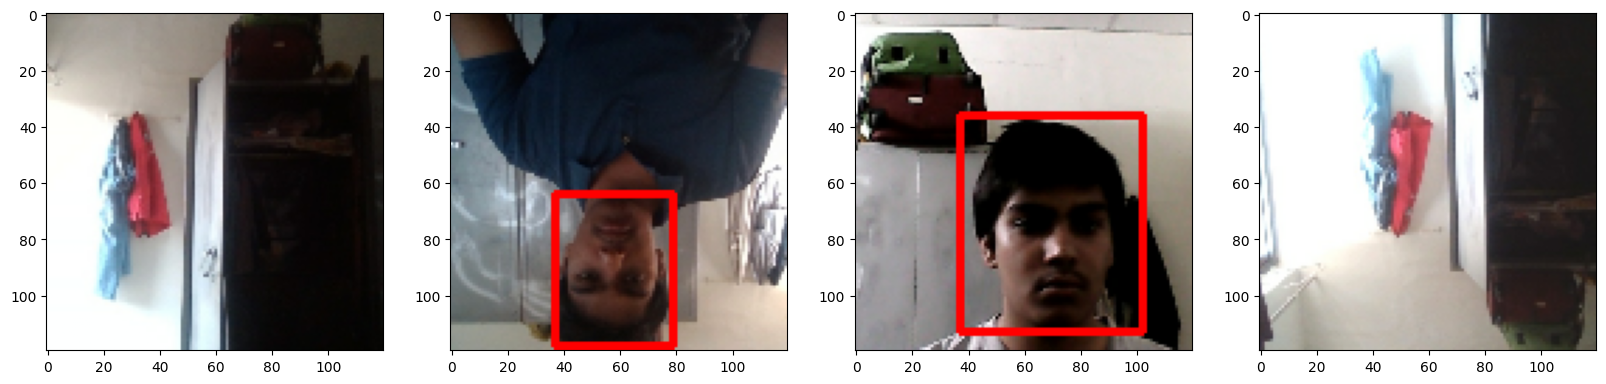

In [98]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = np.copy(test_sample[0][idx])
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                    tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                    tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                    (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

##### 11.2 Save the Model

In [86]:
from tensorflow.keras.models import load_model

In [99]:
facetracker.save(os.path.join('model', 'facetracker.h5'))

c:\Users\Mehul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [101]:
facetracker = load_model(os.path.join('model', 'facetracker.h5'))

##### 11.3 Real Time Detection

In [104]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                    tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                    tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                    (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                    tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                [0,-30])),
                    tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                [80,0])), 
                    (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 102ms/step
